# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, recall_score, precision_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import category_encoders as ce

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('/datasets/hotel_train.csv')
test = pd.read_csv('/datasets/hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

In [5]:
def pr(data):
    display(data.head())
    print(data.info())
    display(data.describe())
    print('Кол-во дубликатов:', data.duplicated().sum())

In [6]:
pr(train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Кол-во дубликатов: 0


In [7]:
pr(test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Кол-во дубликатов: 0


Тренировочные и тестовые данные имеют одинаковое количество и названия колонок. Названия столбцов корректные, пропусков и явных дубликатов в данных нет. Столбец id не содержит полезной информации, удалим его. Колонки lead_time, adults, children и babies содержат целочисленные значения, а имеют вещественный тип float64. Приведём эти столбцы в соответствие их типам. Целевым признаком является столбец is_canceled.

In [8]:
# удалим лишний столбец
train.drop(['id'], axis='columns', inplace=True)
test.drop(['id'], axis='columns', inplace=True)

# приведем столбцы вещественного типа к целочисленному
lst = list(train.select_dtypes('float64').columns)
train[lst] = train[lst].astype('int64')
test[lst] = test[lst].astype('int64')

In [9]:
#После удаление столбца возможно появление дубликатов данных, проверим ещё раз.
print('Количество дубликатов в обучающем датафрейме:', train.duplicated().sum())
print('Количество дубликатов в тестовом датафрейме:', test.duplicated().sum())

Количество дубликатов в обучающем датафрейме: 21377
Количество дубликатов в тестовом датафрейме: 7717


In [10]:
#Обнаружилось огромное количество дубликатов в обоих датасетах. 
#Точную причину их появления в нашем случае выяснить не получится. 
#Это могут быть как технические причины, так и человеческий фактор. 
#Для построения моделей такие записи будут мешать, удалим их.
train.drop_duplicates(inplace=True)

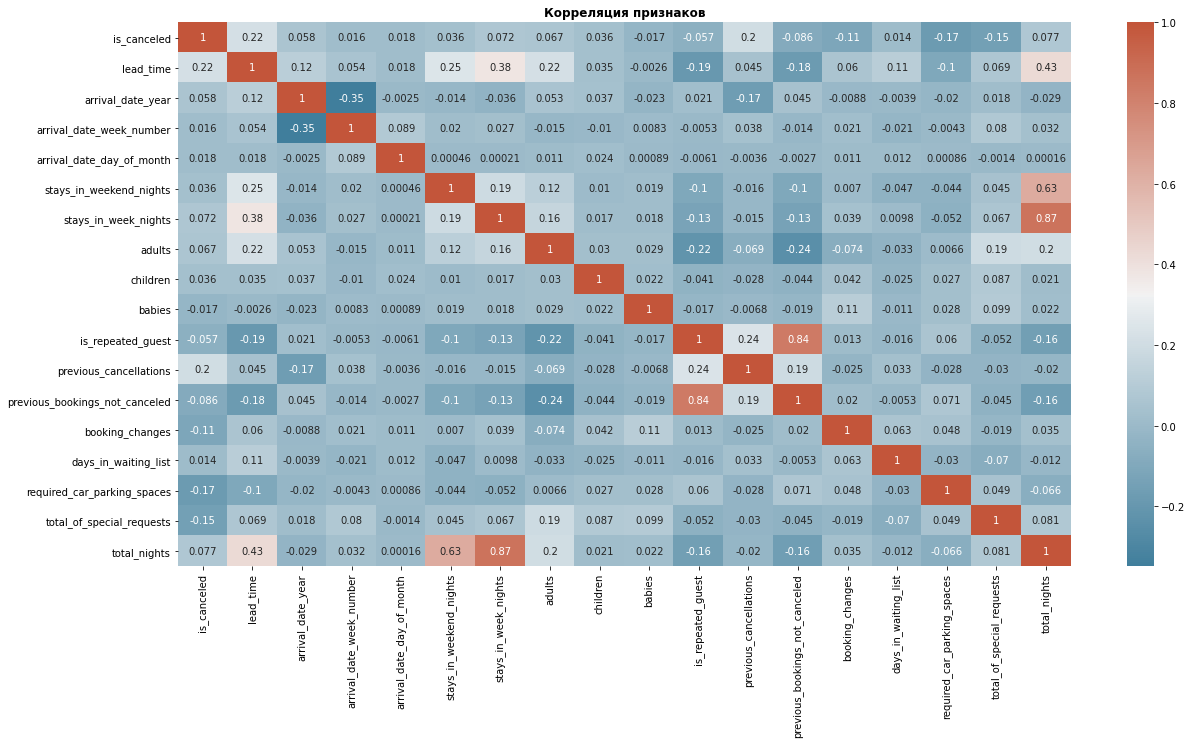

In [11]:
plt.figure(figsize=(20, 10))
plt.title('Корреляция признаков', weight = 'bold')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

Рассмотрим столбцы adults, children, babies. Несмотря на то, что в описании к данным присутствует слово "количество" это категориальные данные

In [12]:
display(train['adults'].value_counts().to_frame())
display(train['children'].value_counts().to_frame())
display(train['babies'].value_counts().to_frame())

,adults
2,32299
1,8688
3,2688
0,164
4,13


,children
0,40471
1,2060
2,1305
3,16


,babies
0,43403
1,444
2,3
9,1
10,1


В столбце babies таблицы train содержатся явные ошибочные значения (выбросы). Удалим строки с количеством детей больше 8.

In [13]:
train = train.loc[train['babies'] < 9]

Проверим, есть ли записи, в которых бронирование осуществлялось без взрослых, без детей и без младенцев.

In [14]:
display(train.loc[(train['adults'] == 0) & (train['babies'] == 0) & (train['children'] == 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,0,48,2016,February,9,21,2,4,0,0,...,0,0,0,B,2,0,Transient-Party,0,0,6
26878,0,122,2016,May,19,5,2,4,0,0,...,0,0,0,E,3,0,Transient,0,0,6
26879,0,122,2016,May,19,5,2,4,0,0,...,0,0,0,E,3,0,Transient,0,0,6
31570,0,256,2016,August,35,21,3,5,0,0,...,0,0,0,A,1,0,Transient,0,0,8
41461,0,0,2015,November,49,30,1,2,0,0,...,1,0,1,A,2,0,Transient,0,0,3
50744,0,52,2016,April,18,30,2,4,0,0,...,0,0,0,E,2,0,Transient-Party,0,1,6
54881,0,108,2016,July,28,5,2,5,0,0,...,0,0,0,A,0,0,Transient,0,0,7
56674,0,4,2016,August,32,5,2,2,0,0,...,0,0,0,A,2,0,Transient,0,2,4
57390,0,88,2016,August,34,16,0,4,0,0,...,0,0,0,D,5,0,Transient,0,2,4
58416,0,36,2016,August,35,27,3,6,0,0,...,0,0,0,A,2,0,Transient,0,2,9


In [15]:
train = train.loc[~((train['adults'] == 0) & (train['babies'] == 0) & (train['children'] == 0))]

Кроме того, у нас есть записи, в которых количество взрослых 0, если в таких записях есть младенцы, надо тоже исключить такие строки, потому что младенцев без взрослых в отель не заселят и это явная ошибка. Проверим наши данные на такое совпадение.

In [16]:
display(train.loc[(train['adults'] == 0) & (train['babies'] > 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22534,0,6,2015,December,51,18,0,1,0,2,...,0,0,0,B,0,0,Transient-Party,0,2,1
44049,1,22,2015,December,50,9,1,4,0,2,...,0,0,0,B,1,0,Transient,0,1,5
52923,0,14,2016,June,24,9,0,3,0,2,...,0,0,0,B,2,0,Transient,0,2,3


In [17]:
train = train.loc[~((train['adults'] == 0) & (train['babies'] > 0))]

Так как младенцев равное 2 в обоих таблицах крайне мало, сделаем из этого столбца признак наличия младенцев. То есть младенцы или есть или их нет вообще. Для этого приравняем количество младенцев равное двум к единице и для корректности переименуем этот столбец в has_babies.

In [18]:
train.loc[train['babies'] == 2, 'babies'] = 1
train.rename(columns={'babies': 'has_babies'}, inplace=True)
test.loc[test['babies'] == 2, 'babies'] = 1
test.rename(columns={'babies': 'has_babies'}, inplace=True)
train['has_babies'].value_counts()

0    43388
1      444
Name: has_babies, dtype: int64

Рассмотрим столбец required_car_parking_spaces.

In [19]:
display(train['required_car_parking_spaces'].value_counts().to_frame())
display(test['required_car_parking_spaces'].value_counts().to_frame())

,required_car_parking_spaces
0,40234
1,3586
2,11
3,1


,required_car_parking_spaces
0,30935
1,1468
2,6
8,2
3,1


Как и в случае с младенцами наблюдаем небольшое количество случаев, когда есть необходимость бронирования мест для автомобилей больше одного. Перестроим эту колонку в признаковую и переименуем ее в is_required_car_parking_spaces

In [20]:
train.loc[train['required_car_parking_spaces'] > 1, 'required_car_parking_spaces'] = 1
train.rename(columns={'required_car_parking_spaces': 'is_required_car_parking_spaces'}, inplace=True)
test.loc[test['required_car_parking_spaces'] == 2, 'required_car_parking_spaces'] = 1
test.rename(columns={'required_car_parking_spaces': 'is_required_car_parking_spaces'}, inplace=True)

In [21]:
categorical_columns = train.loc[:,  (train.dtypes == 'object')].columns
datas = [train, test] #Проверим категориальные столбцы на скрытые дубликаты
for data in datas:
    for column in categorical_columns:
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
Количество уникальных значений arrival_date_month: 12
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']
Количество уникальных значений meal: 5
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM

In [22]:
#Исправляем
for data in datas: 
    for column in ['meal', 'reserved_room_type']:
        data[column] = data[column].str.strip()
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7
['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7


Изучим целевой признак, столбец is_canceled.

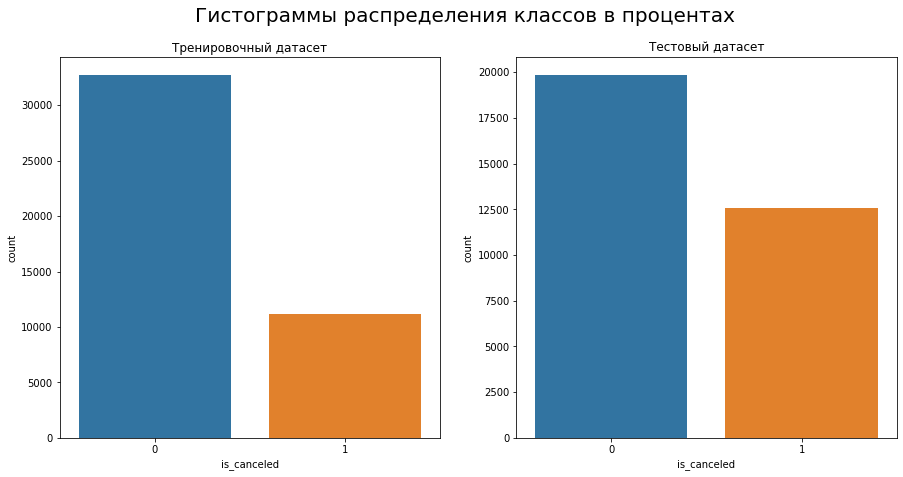

Тренировочный датасет, класс 0: 74.57%, класс 1: 25.43%
Тестовый датасет, класс 0:      61.15%, класс 1: 38.85%


In [23]:
# вывод гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Гистограммы распределения классов в процентах', fontsize=20)
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.countplot(data=train, x='is_canceled', ax=axes[0])
sns.countplot(data=test, x='is_canceled', ax=axes[1])
plt.show()

# вывод распределения классов в процентах
print(f"Тренировочный датасет, класс 0: {1 - train['is_canceled'].mean():.2%}, класс 1: {train['is_canceled'].mean():.2%}")
print(f"Тестовый датасет, класс 0:      {1 - test['is_canceled'].mean():.2%}, класс 1: {test['is_canceled'].mean():.2%}")

Видно, что выборки не стратифицированные, но расхождение не велико. Кроме того, имеется явный дисбаланс классов - более 1/3 клиентов отказавшихся от брони и приблизительно 2/3 клиентов, которые воспользовались бронированием. При моделировании необходимо это учитывать и применять методы балансировки классов.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [24]:
#Создадим отдельный дф с нужными признаками
df_for_profit = test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
df_for_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,1,January,A,1
1,1,January,A,4
2,1,January,A,4
3,1,January,A,4
4,1,January,A,7


In [25]:
#Добавим к получившейся таблице значения стоимости комнат и обслуживания
room_dict = pd.DataFrame({'reserved_room_type' : [i for i in sorted(df_for_profit.reserved_room_type.unique())],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})
df_for_profit = df_for_profit.merge(room_dict, on='reserved_room_type', how='left')

In [26]:
#Добавим коэффициенты по сезону
month_dict = pd.DataFrame({'arrival_date_month' : [i for i in df_for_profit.arrival_date_month.unique()],
                          'koeff' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})
df_for_profit = df_for_profit.merge(month_dict, on='arrival_date_month', how='left')
df_for_profit

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff
0,1,January,A,1,1000,400,1.0
1,1,January,A,4,1000,400,1.0
2,1,January,A,4,1000,400,1.0
3,1,January,A,4,1000,400,1.0
4,1,January,A,7,1000,400,1.0
...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.4
32408,0,August,A,7,1000,400,1.4
32409,0,August,A,7,1000,400,1.4
32410,0,August,D,7,550,150,1.4


In [27]:
#Далее создадим функцию для рассчета прибыли и убытка в зависимости от отмены брони
def profit(data):
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['koeff'] * data['total_nights']
        expenses = data['service_price'] * (1 + data['total_nights'] // 2)
    else:
        income = 0
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    profit = income - expenses
    return profit

In [28]:
df_for_profit['total_profit'] = df_for_profit.apply(profit, axis=1)

In [29]:
display(df_for_profit)
profit_without_deposite = df_for_profit['total_profit'].sum()
print('Прибыль с января по август 2017 г. без депозита составляет:', profit_without_deposite, 'руб.')

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff,total_profit
0,1,January,A,1,1000,400,1.0,-1400.0
1,1,January,A,4,1000,400,1.0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0
4,1,January,A,7,1000,400,1.0,-1400.0
...,...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.4,6800.0
32408,0,August,A,7,1000,400,1.4,8200.0
32409,0,August,A,7,1000,400,1.4,8200.0
32410,0,August,D,7,550,150,1.4,4790.0


Прибыль с января по август 2017 г. без депозита составляет: 32582920.0 руб.


Итак, прибыль за отчестный период у нас составила 32_582_920 руб. Теперь примемся за разработку ML модели, которая поможет нам окупить затраты на разработку модели и ее внедрение, а также принести прибыль. Для этого подготовим данные.

### Шаг 4. Разработка модели ML

Далее нужно выбрать из них самую качественную, ту, которая удовлетворяла бы нашим условиям. Целевой показатель для нас - recall - тк именно отказники, которым модель ошибочно присвоит ложный признак, принесут убытки отелю.

In [30]:
# создадим признаки для моделей
features_train = train.drop(columns=['arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_month', 'is_canceled'], axis=1)
features_test = test.drop(columns=['arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_month', 'is_canceled'], axis=1)

# выделим целевой признак
target_train = train['is_canceled']
target_test = test['is_canceled']


In [31]:
#Кодировка с помощью Binary Encoder
binary = ce.BinaryEncoder()
binary.fit(features_train)
features_train = binary.transform(features_train)
features_test = binary.transform(features_test)

Dummy Classifier

In [32]:
#Строим дамми для проверки на адекватность
dummy_model = DummyClassifier(random_state=12345)
dummy_model.fit(features_train, target_train)
prediction_dummy = dummy_model.predict(features_train)
print("Accuracy:", accuracy_score(target_train, prediction_dummy))
print("F1:", f1_score(target_train, prediction_dummy))
print("ROC_auc:", roc_auc_score(target_train, prediction_dummy))
dummy_proba = dummy_model.predict_proba(features_train)[:, 1]
fpr_dummy, tpr_dummy, threshold_dummy = roc_curve(target_train, dummy_proba)

Accuracy: 0.7456880817667457
F1: 0.0
ROC_auc: 0.5


In [33]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [34]:
#Функция для сверки результатов
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("Accuracy:", round(accuracy_score(target, prediction), 3))
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, prediction), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))
    return prediction

In [35]:
#Сделаем график кроссвалидации чтобы понять, что наши результаты стабильны и не случайны
def cross_val_plot(model, features, target):
    plt.plot(cross_val_score(model, features, target, cv=10, scoring='recall', n_jobs=-1))
    plt.title('Показатели Recall по блокам кроссвалидации')
    plt.xlabel('Блок')
    plt.ylabel('Метрика Recall')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.show()

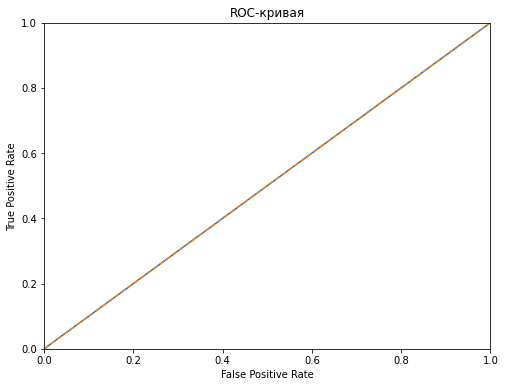

Accuracy: 0.612
F1: 0.0
ROC_auc: 0.5
Precision: 0.0
Recall: 0.0


In [36]:
dummy_pred = results(dummy_model, features_test, target_test) #Строим ROC-AUC для Dummy Classifier

In [37]:
param_grid = {'C': [10, 100, 1.0],
'solver': ['lbfgs','liblinear'],
'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(), param_grid, scoring = 'recall', verbose = 1)
grid_lr.fit(features_train, target_train)

print(grid_lr.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [55]:
param_grid = {'max_depth': range(1, 52, 5),
'min_samples_leaf': range(1, 12, 2),
'min_samples_split': range(1, 12, 2)}
grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'recall', verbose = 2, n_jobs = -1)
grid_dtc.fit(features_train, target_train)

print(grid_dtc.best_params_)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [58]:
param_grid = {'max_depth': range(1, 52, 10),
'n_estimators': range(1, 52, 10),
'min_samples_leaf': range(1, 12, 5),
'min_samples_split': range(1, 12, 5)}
grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'recall', verbose = 2, n_jobs = -1)
grid_rfc.fit(features_train, target_train)

print(grid_rfc.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=11; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=11; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=11; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=11; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samp

In [59]:
best_metrics_train = pd.DataFrame(data=[('Logistic Regression', 
                                        round(grid_lr.best_score_, 5)), 
                                        ('Decision Tree', 
                                        round(grid_dtc.best_score_, 5)), 
                                        ('Random Forest', 
                                        round(grid_rfc.best_score_, 5))],
                                        columns=['model', 'recall'])
best_metrics_train

,model,recall
0,Logistic Regression,0.27309
1,Decision Tree,0.27011
2,Random Forest,0.33175


RFC

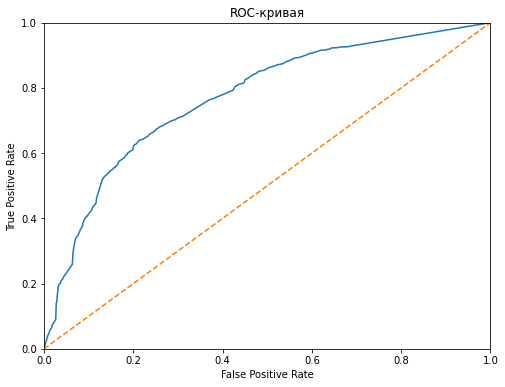

Accuracy: 0.719
F1: 0.561
ROC_auc: 0.672
Precision: 0.714
Recall: 0.462
Лучший Recall на обучающей выборке: 0.809317393684979


In [60]:
model_RFC = RandomForestClassifier(random_state=12345, max_depth = 31, min_samples_leaf = 6, min_samples_split = 11, n_estimators = 1)
model_RFC.fit(features_train, target_train)
prediction_RFC = results(model_RFC, features_test, target_test)
print(f'Лучший Recall на обучающей выборке: {model_RFC.score(features_train, target_train)}')

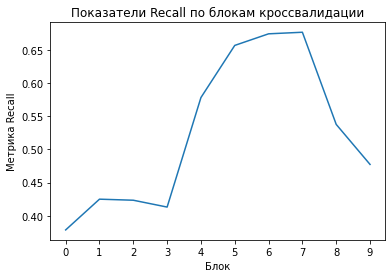

In [61]:
cross_val_plot(model_RFC, features_test, target_test)

In [62]:
best_metrics = pd.DataFrame(data=[('Random Forest', round(accuracy_score(target_test, prediction_RFC), 3), 
                                  round(f1_score(target_test, prediction_RFC), 3), 
                                  round(roc_auc_score(target_test, prediction_RFC), 3),
                                  round(precision_score(target_test, prediction_RFC), 3), 
                                  round(recall_score(target_test, prediction_RFC), 3))],
                                 columns=['model', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
best_metrics

,model,accuracy,f1,roc_auc,precision,recall
0,Random Forest,0.719,0.561,0.672,0.714,0.462


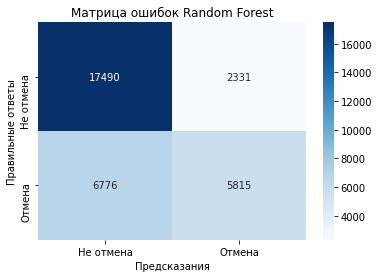

In [63]:
def heatmatrix(title, prediction):
    sns.heatmap(confusion_matrix(target_test, prediction), annot=True, cmap='Blues', fmt='g', 
               xticklabels=['Не отмена', 'Отмена'], yticklabels=['Не отмена', 'Отмена'])
    plt.title(f'Матрица ошибок {title}')
    plt.xlabel('Предсказания')
    plt.ylabel('Правильные ответы')
    plt.show()
models = [('Random Forest', prediction_RFC)]
for title, prediction in models:
    heatmatrix(title, prediction)

In [64]:
predictions = [('prediction_rf', prediction_RFC)]
for name, prediction in predictions:
    series = pd.Series(prediction).to_frame()
    series.columns = [name]
    df_for_profit = df_for_profit.merge(series, how='left', left_index=True, right_index=True)

In [65]:
def predicted_profit(data, col):
    global income
    global expenses
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['koeff'] * data['total_nights']
        expenses = data['service_price'] * (1 + data['total_nights'] // 2)
    elif (data['is_canceled'] == 1) and (data[col] == 0):
        income = 0
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    elif (data['is_canceled'] == 1) and (data[col] == 1):
        income = (data['price_per_night'] * data['koeff'] * .8) + (data['service_price'] * .8)
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    profit = income - expenses
    return profit

In [66]:
for new_col, col in [('profit_rf', 'prediction_rf')]:
    df_for_profit[new_col] = df_for_profit.apply(predicted_profit, col=col, axis=1)

In [67]:
display(df_for_profit)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff,total_profit,prediction_rf,profit_rf
0,1,January,A,1,1000,400,1.0,-1400.0,1,-280.0
1,1,January,A,4,1000,400,1.0,-1400.0,0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0,0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0,0,-1400.0
4,1,January,A,7,1000,400,1.0,-1400.0,0,-1400.0
...,...,...,...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.4,6800.0,0,6800.0
32408,0,August,A,7,1000,400,1.4,8200.0,1,8200.0
32409,0,August,A,7,1000,400,1.4,8200.0,0,8200.0
32410,0,August,D,7,550,150,1.4,4790.0,0,4790.0


In [68]:
print('Прибыль после обучения RF:', df_for_profit['profit_rf'].sum())

Прибыль после обучения RF: 39416336.0


In [69]:
print('Прибыль от использования RF:', (df_for_profit['profit_rf'].sum() - df_for_profit['total_profit'].sum()))

Прибыль от использования RF: 6833416.0


Как видим, нас больше всего устраивает модель Случайный лес. Она могла бы принести около 7 млн руб дополнительной прибыли за отчетный период, что перекрывает с лихвой затраты в 400_000 руб на ее разработку. У нее хороший F1, отличный recall. Сохраним эту модель и будем пользоваться ей в дальнейшем.

### Шаг 5. Опишите портрет «ненадёжного» клиента

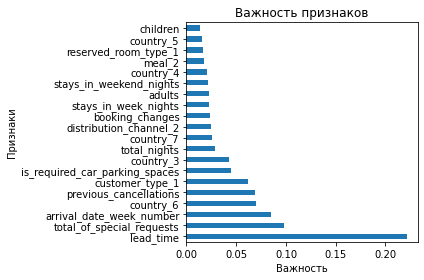

In [70]:
#Посмотрим, какие признаки выделила наша модель
pd.Series(model_RFC.feature_importances_, features_train.columns).nlargest(20).plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

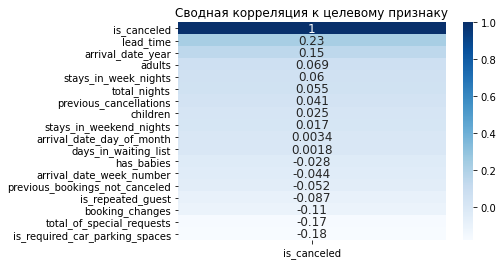

In [71]:
#Проверим корреляцию между признаками к целевому признаку на обобщенном датафрейме
hotel_concat = pd.concat([train, test])
sns.heatmap(hotel_concat.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
plt.title('Сводная корреляция к целевому признаку')
plt.show()

Из тех значений, что не подверглись кодированию, мы можем отметить следующие зависимости, на которые обратила внимание модель:

Чем больше времени между бронированием и выездом, тем выше вероятность отказа. Есть время передумать.
Чем больше специальных отметок, тем ниже вероятность отказа. Гости, которые оставляют отметки или пожелания, заинтересованы в том, чтобы снять номер.
Если есть требования к парковочным местам, то вероятность отказа от бронирования ниже. Если человек едет на машине, значит путешествие, скорее всего, запланировано и меньше соблазна отменять бронь.
Если есть отмены брони, то есть и вероятность отказа. У клиента наблюдается модус поведения.
Чем больше было неотмененных броней у клиента ранее, тем ниже вероятность отмены.
Чем выше количество изменений параметров заказа, тем ниже вероятность отмены брони. Опять же, если человек оставляет какие то требования, то значит он, скорее всего, заинтересован в брони.
Если гость до этого бронировал номер, то ниже вероятность отмены в дальнейшем. значит клиент проверенный.
Время года также имеет значение.

In [72]:
#Добавим к рассматриваемому датасету столбец с предсказаниями, чтобы делать сравнительные таблицы
prediction_dt = pd.Series(prediction_RFC).to_frame()
prediction_dt.columns = ['prediction_dt']
hotel_test = test.merge(prediction_dt, left_index=True, right_index=True)
hotel_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,is_required_car_parking_spaces,total_of_special_requests,total_nights,prediction_dt
0,1,74,2017,January,1,1,1,0,2,0,...,0,0,A,0,0,Transient,0,0,1,1
1,1,62,2017,January,1,1,2,2,2,0,...,0,0,A,0,0,Transient,0,1,4,0
2,1,62,2017,January,1,1,2,2,2,0,...,0,0,A,0,0,Transient,0,1,4,0
3,1,71,2017,January,1,1,2,2,1,0,...,0,0,A,0,0,Transient,0,1,4,0
4,1,172,2017,January,1,1,2,5,2,0,...,0,0,A,0,0,Transient,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164,2017,August,35,31,2,4,2,0,...,0,0,A,0,0,Transient,0,0,6,0
32408,0,21,2017,August,35,30,2,5,2,0,...,0,0,A,0,0,Transient,0,2,7,1
32409,0,23,2017,August,35,30,2,5,2,0,...,0,0,A,0,0,Transient,0,0,7,0
32410,0,34,2017,August,35,31,2,5,2,0,...,0,0,D,0,0,Transient,0,4,7,0


In [73]:
#Создадим функцию для сравнения кат признаков относительно фактическому и предсказанному целевому признаку
def cat_comparison(column):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f'Сравнение зависимости отмены бронирования от категорий {column}', fontweight="bold")
    sns.barplot(data=test, x=column, y='is_canceled', ax=ax[0])
    ax[0].set_title('Фактические отмены')
    ax[0].set_xlabel('Категории')
    ax[0].set_ylabel('Зависимость целевого признака')
    sns.barplot(data=hotel_test, x=column, y='prediction_dt', ax=ax[1])
    ax[1].set_title('Предсказанные отмены')
    ax[1].set_xlabel('Категории')
    ax[1].set_ylabel('Зависимость целевого признака')
    plt.show()
    val_counts = train.value_counts(column).to_frame()
    val_counts.columns = ['share']
    val_counts['share'] = (val_counts['share'] / val_counts['share'].sum()).apply(lambda x: '{0:.2%}'.format(x))
    display(val_counts)

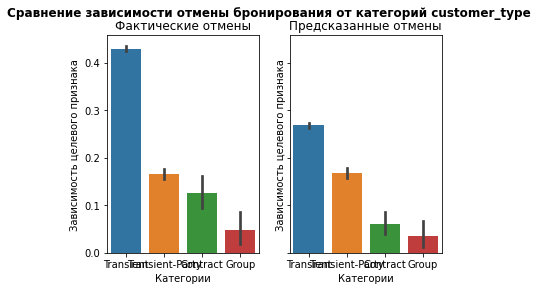

,share
customer_type,
Transient,80.66%
Transient-Party,14.48%
Contract,4.28%
Group,0.59%


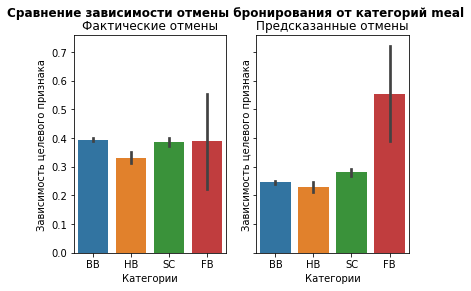

,share
meal,
BB,81.09%
SC,10.97%
HB,7.63%
FB,0.31%


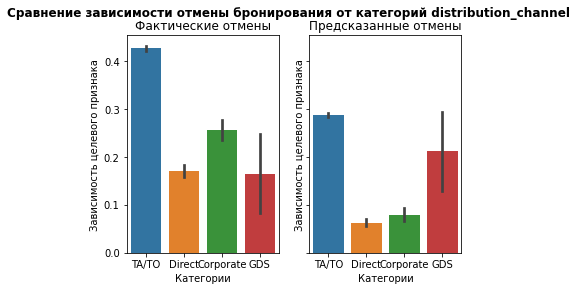

,share
distribution_channel,
TA/TO,80.24%
Direct,13.27%
Corporate,6.28%
GDS,0.21%


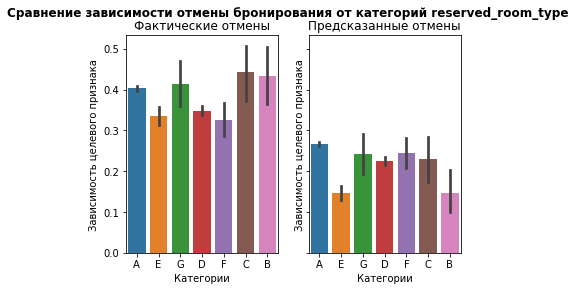

,share
reserved_room_type,
A,69.43%
D,19.21%
E,5.14%
F,2.69%
B,1.69%
G,1.32%
C,0.52%


In [74]:
cols = ['customer_type', 'meal', 'distribution_channel', 'reserved_room_type']
for col in cols:
    cat_comparison(col)

Выводы по категориальным столбцам:

По типу заказчика больше всех отменяет категория Transient, но модель сместила выбор в пользу самой низкой - Group, что не так важно, учитывая общую долю этой категории менее 1%.
По категориям meal у нас нет особых скачков, все категории где-то на уровне 0,4. Модель отдала предпочтение категории FB, что также незначительно, тк она занимает менее 1% и вряд ли способна навредить метрикам предсказаний.
По категориям distribution_channel выделяются TA/TO и Corporate. Что касается модели, то наблюдается та же картина, что и в предыдущих категориях - заметен скачок на категории GDS, которая занимает менее 1%.
По reserved_room_type мы уже отмечали, что отменяют в основном категории А, В, С, G. Модель в общих чертах воспроизвела эти зависимости.

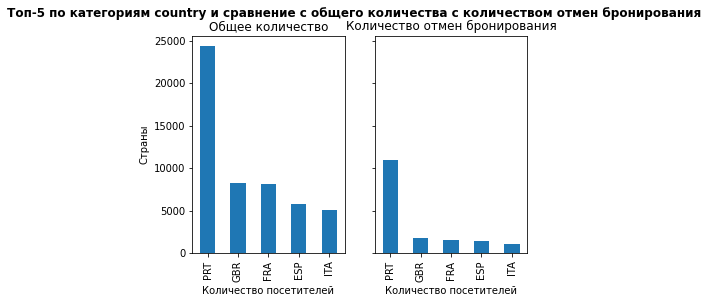

In [75]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Топ-5 по категориям country и сравнение с общего количества с количеством отмен бронирования', fontweight="bold")
hotel_concat.value_counts('country').nlargest(5).plot(kind='bar', ax=ax[0])
ax[0].set_title('Общее количество')
ax[0].set_xlabel('Количество посетителей')
ax[0].set_ylabel('Страны')
hotel_concat.query('is_canceled == 1')['country'].value_counts().nlargest(5).plot(kind='bar', ax=ax[1])
ax[1].set_title('Количество отмен бронирования')
ax[1].set_xlabel('Количество посетителей')
plt.show()

Как видим, большинство посетителей приезжает из Португалии. Около половины из них отменяет бронирование. И это идет вразрез с практикой уроженцев других стран.


Какие выводы можно сделать насчет "ненадежных клиентов":

На ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа.
В то же время есть признаки-"якори", которые снижают вероятность отмены - долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента.
Конечно же, забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.
Львиную долю гостей составляют посетители из Португалии, которые, к тому же, непропорционально часто отменяют брони.

### Шаг 6. Напишите общий вывод

Итак, мы провели исследование, спрогнозировали отток клиентов, подведем итог:

Мы провели предобработку данных, удалили лишний столбец id, неинформативный в нашем деле, выявили дубликаты, которые решено было оставить, тк мы не знаем их истинную природу. Также исправили категориальные значения, в которых были ошибки и удалили единичные строки с нулевым количеством постояльцев.

В исследовательском анализе мы выявили дисбаланс целевого признака, отменяется 37-39 % брони. В дальнейшем при обучении модели данная проблема была решена. Этот признак больше всего коррелирует с целевым. В нем удалили выбросы, как и в столбце total_nights. Остальные признаки мы не трогали.

Далее подготовили данные для ML, очистили вышеозначенные столбцы от выбросов, разделили на признаки, в некоторых столбцах выявили категории более четко, провели масштабирование и кодирование через Binary Encoder нашей тренировочной выборки. Увеличили ее за счет увеличения положительного целевого признака. Но сделали это не для балансировки, но для увеличения тренировочной выборки, которая была очень мала по сравнению с тестовой.

Далее мы обучили наши модели. Выбрали три: лог регрессия, дерево решений, случайный лес. В качестве целевой метрики выбрали recall, тк нам было важно не отправить потенциальных отказников в список тех, кто точно не откажется от брони. Ведь именно в этом случае мы теряли деньги.

Из созданных моделей лучше всего была модель случайного леса с самым высоким показателем ROC_AUC и F1, но она нас не устраивала по показателю recall, который, как известно, был целевым. Поэтому мы будем использовать модель логистической регрессии, которая лишь слегка хуже, но у которой recall на тестовой выборке выдал 0,764. Это помогло бы нам увеличить прибыль на тестовой выборке до 11 млн руб. И это является достижением и позволяет окупить затраты в 400_000 руб на создание модели.

Оценивая портрет "ненадежного" заемщика пришли к выводу, что на ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа. В то же время долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента. Конечно же, забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.

Особенно стоит обратить внимание на посетителей из Португалии. Они составляют значительную долю бронирований в отеле, но и частенько (около половины общего количества) их отменяют. Возможно, стоит отдельно выделить данную категорию гостей и понаблюдать. Если доля отмен будет увеличиваться, обложить их депозитом отдельно. Впрочем, модель и так достаточно хорошо предсказывает отмены.